### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr, ks_2samp


from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer



**Reading the data**

In [2]:
customers_df = pd.read_csv('Mall_Customers.csv')

In [3]:
df_shape = customers_df.shape
print(f"Number of rows: {df_shape[0]}, number of columns: {df_shape[1]}")

Number of rows: 200, number of columns: 5


In [4]:
customers_df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
# Renaming the columns
customers_df.rename(columns={'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'Score'}, inplace=True)

In [6]:
customers_df.describe()

,CustomerID,Age,Income,Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
customers_df.dtypes

CustomerID     int64
Gender        object
Age            int64
Income         int64
Score          int64
dtype: object

### Exploratory Data Analysis

In [8]:
# Checking null values
customers_df.isnull().sum()

CustomerID    0
Gender        0
Age           0
Income        0
Score         0
dtype: int64

There are no null values.

##### **Data Distribution**

In [9]:
customers_df.columns

Index(['CustomerID', 'Gender', 'Age', 'Income', 'Score'], dtype='object')

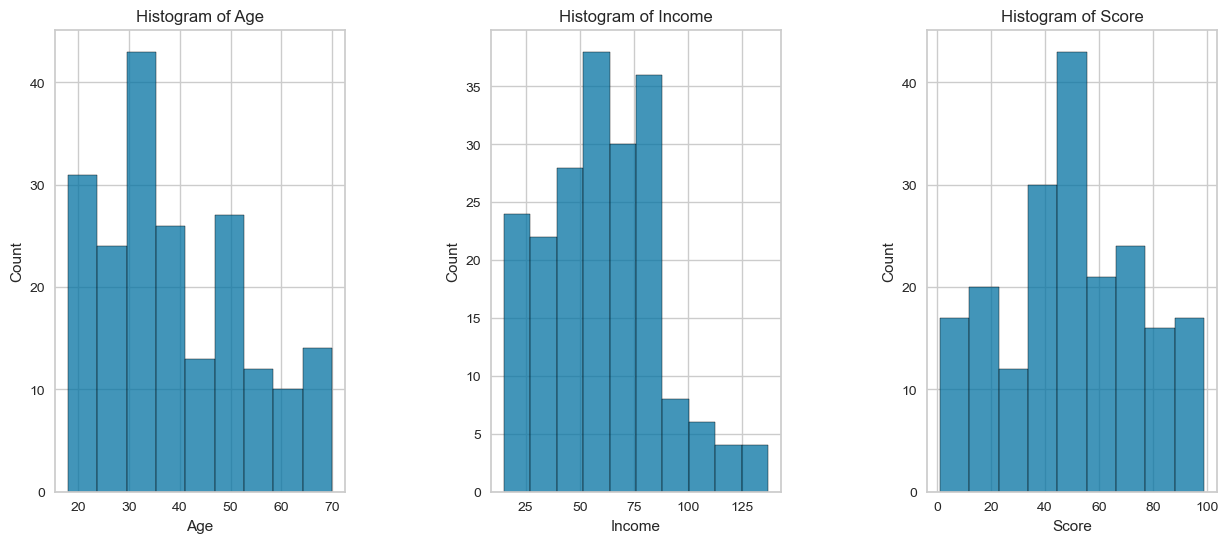

In [10]:
num_columns = ['Age', 'Income', 'Score']

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for i, ax in enumerate(axes):
    sns.histplot(customers_df[num_columns[i]], ax=ax)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax.set_title(f"Histogram of {num_columns[i]}")
plt.show()

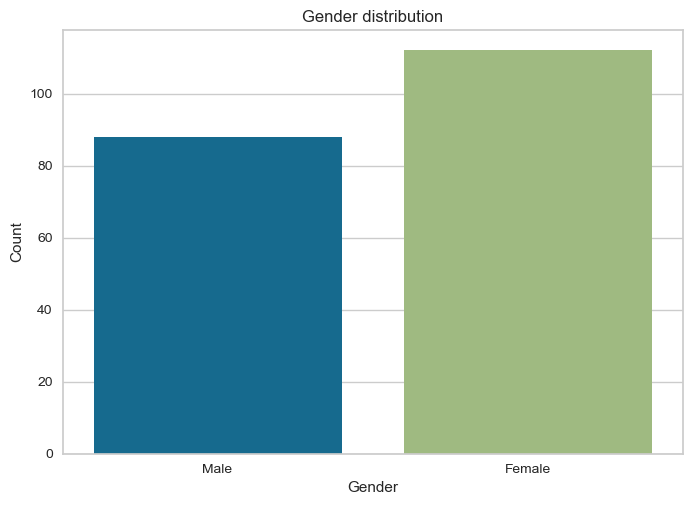

In [11]:
# Gender bar chart

sns.countplot(x='Gender', data=customers_df)

plt.title('Gender distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#### **Variables Correlations**

In [12]:
males_df = customers_df[customers_df['Gender'] == 'Male']
females_df = customers_df[customers_df['Gender'] == 'Female']

In [13]:
def plot_correlation_by_gender(col1, col2):
    male_corr_coef, _ = pearsonr(males_df[col1].values, males_df[col2].values)
    female_corr_coef, _ = pearsonr(females_df[col1].values, females_df[col2].values)
    
    plt.figure(figsize=(10, 8))
    sns.lmplot(x=col1, y=col2, data=customers_df, hue='Gender', aspect=1.5)
    
    plt.text(0.95, 0.95, f'Pearson: {male_corr_coef:.2f}', color='blue', 
             transform=plt.gca().transAxes, ha='right', va='top')
    plt.text(0.95, 0.90, f'Pearson: {female_corr_coef:.2f}', color='#d97900', 
             transform=plt.gca().transAxes, ha='right', va='top')  
    
    plt.show()

/home/lok/anaconda3/envs/ML_ENV/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

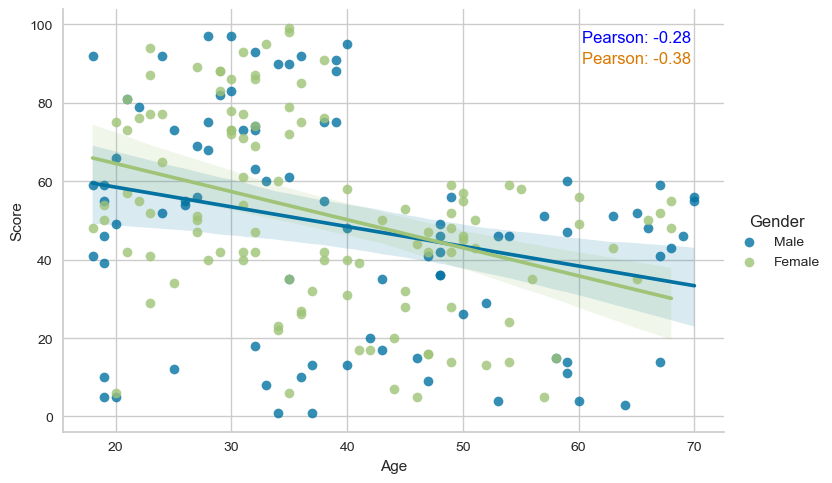

In [14]:
plot_correlation_by_gender('Age', 'Score')

The Pearson correlation coefficient between `Age` and `Score` signifies a negative moderate linear relationship, though the relationship is not very strong and other factors likely play role.

/home/lok/anaconda3/envs/ML_ENV/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

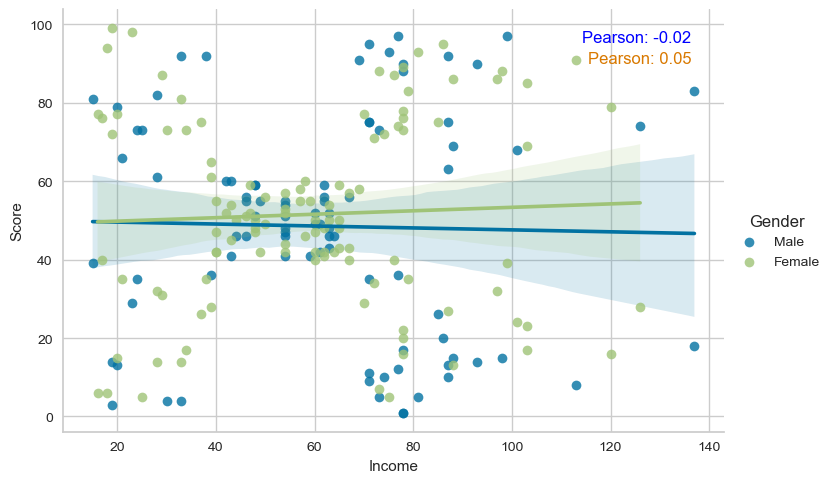

In [15]:
plot_correlation_by_gender('Income', 'Score')

The Pearson correlation coefficient indicates that there is very weak relationship between ` Scorenual Income` for both genders. This suggests that the variable are nearly independent of each other in terms of their linear relationship.

/home/lok/anaconda3/envs/ML_ENV/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

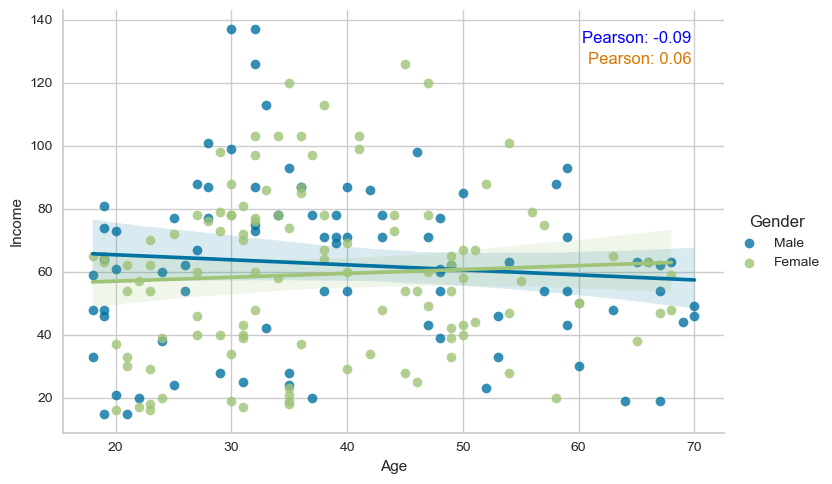

In [16]:
plot_correlation_by_gender('Age', 'Income')

The Pearson correlation coefficient between `Age` and `Annual Income` indicates a weak linear relationship between these variables for both males and females.

#### **Kolmogorov-Smirnov test**

In [17]:
def print_ks_test_pvalue(col):
    print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(ks_2samp(males_df[col], females_df[col])[1]))

In [18]:
for col in num_columns:
    print_ks_test_pvalue(col)

Kolgomorov-Smirnov test p-value: 0.49
Kolgomorov-Smirnov test p-value: 0.78
Kolgomorov-Smirnov test p-value: 0.29


The `Kolmogorov-Smirnov` test is used to compare `Age`, `Annual Income`, and `Score` distributions for males and females. The above p-values indicate that there is no significant between the two distributions.Therefore, will not use the `Gender` columns in the clustering.

### K-means clustering

#### **Standardize Data**

In [19]:
scaler = StandardScaler()

data_std = pd.DataFrame(scaler.fit_transform(customers_df[num_columns]), columns = num_columns)

data_std

,Age,Income,Score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [20]:
data_std.describe()

,Age,Income,Score
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


#### **Modeling**

In [21]:
inertia = [] # List to store the within-cluster sum of squares

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(data_std)
    inertia.append(kmeans.inertia_)

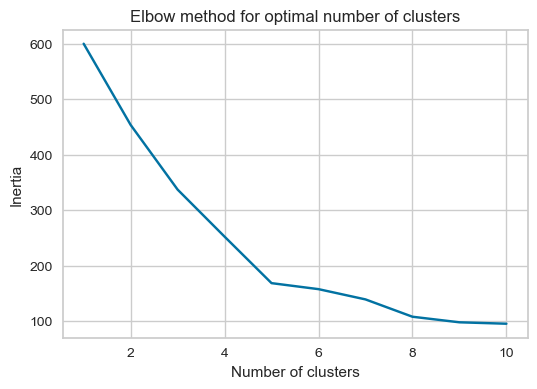

In [22]:
# Plot the elbow graph
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), inertia)
plt.title('Elbow method for optimal number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

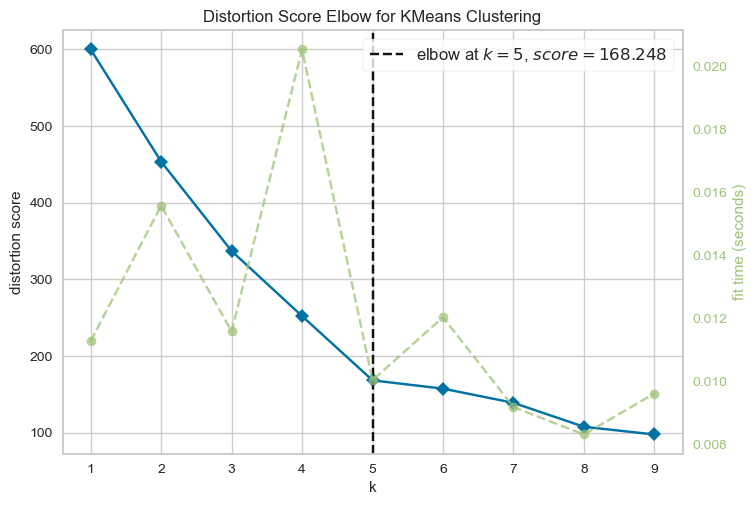

In [23]:

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(data_std)
visualizer.show()
plt.show()

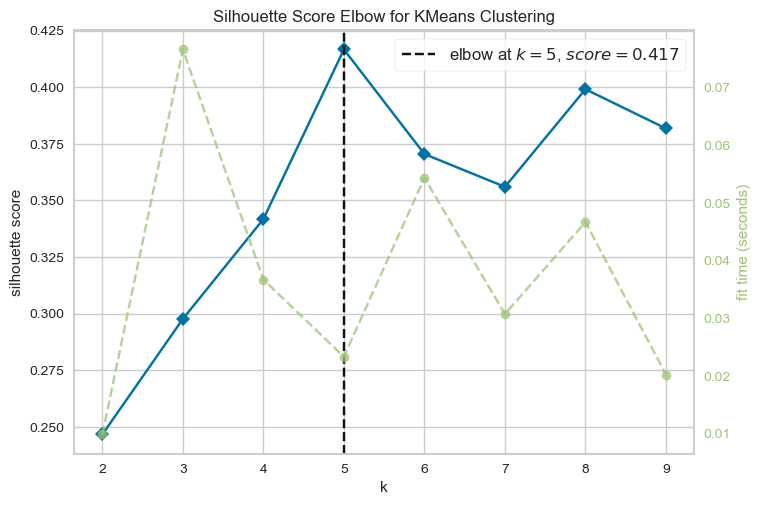

In [24]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(data_std)
visualizer.show()
plt.show()


#### **Clustering Results**

In [25]:
# Create a 3D scatter plot

def _3d_scatter_plot(cluster_col):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(customers_df['Age'], customers_df['Income'], 
                        customers_df['Score'], c=customers_df[cluster_col],
                        cmap='viridis', s=100, alpha=0.7)
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income')
    ax.set_zlabel('Score')
    ax.set_title(f'3D Clustering of the data, {cluster_col}')




    plt.show()

**For k = 5**

In [26]:
# for k = 5
kmeans = KMeans(n_clusters=5, random_state=1)
customers_df['Cluster_k_5'] = kmeans.fit_predict(data_std)


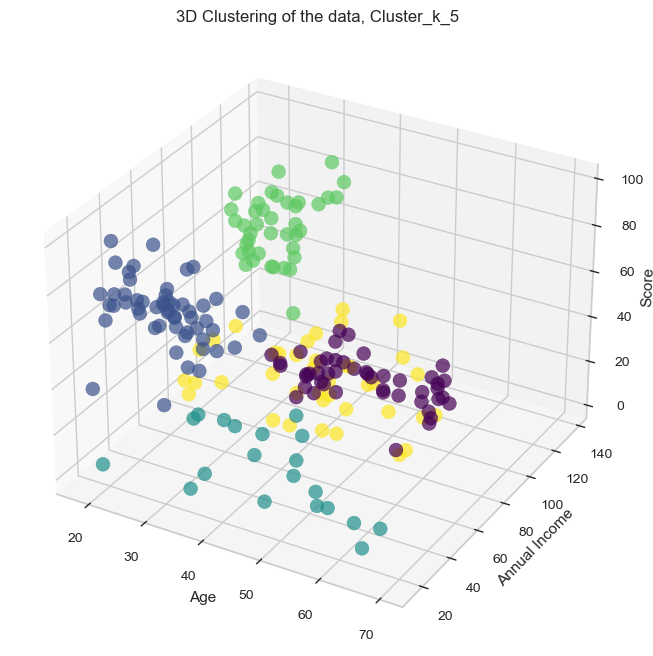

In [27]:
_3d_scatter_plot('Cluster_k_5')

/home/lok/anaconda3/envs/ML_ENV/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


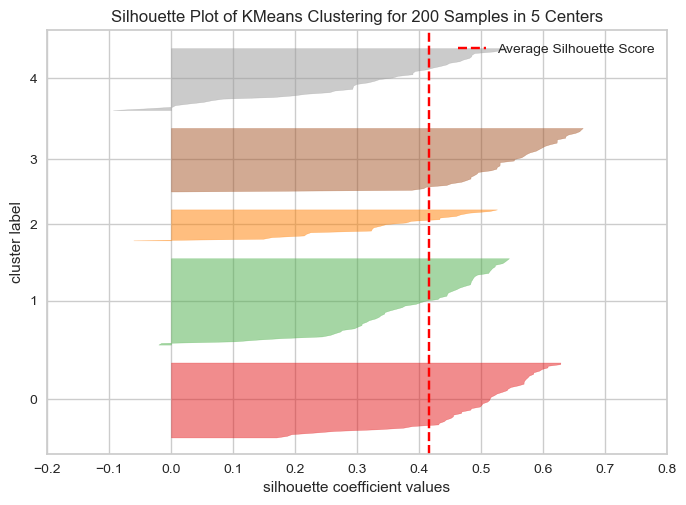

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 200 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:

sil_visualizer = SilhouetteVisualizer(kmeans)
sil_visualizer.fit(data_std)
sil_visualizer.show()


In [29]:
score_k_5 = silhouette_score(data_std, customers_df['Cluster_k_5'])

print("Silhouette Score for k = 5:", score_k_5)

Silhouette Score for k = 5: 0.41664341513732767
